In [1]:
## Necessary packages
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import warnings
warnings.filterwarnings("ignore")

# 1. TimeGAN model
from timegan import timegan
# 2. Data loading
from data_loading import real_data_loading, sine_data_generation, real_data_loading_sce1
# 3. Metrics
from metrics.discriminative_metrics import discriminative_score_metrics
from metrics.predictive_metrics import predictive_score_metrics
from metrics.visualization_metrics import visualization

import tensorflow as tf

import os, time

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = "2"
config = tf.compat.v1.ConfigProto() # Another Version: config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [3]:
## Data loading
data_name = 'stock'
seq_len = 24
per_test = 0.05 # 5% as testing

if data_name in ['stock', 'energy']:
    train_data, test_data = real_data_loading_sce1(data_name, seq_len, per_test)
elif data_name == 'sine':
    # Set number of samples and its dimensions
    no, dim = 10000, 5
    train_data, test_data = sine_data_generation(no, seq_len, dim)
    
print(data_name + ' dataset is ready.')

stock dataset is ready.


In [4]:
np.array(train_data).shape, np.array(test_data).shape

((3476, 24, 6), (161, 24, 6))

In [5]:
## Newtork parameters
parameters = dict()

parameters['module'] = 'gru' 
parameters['hidden_dim'] = 24
parameters['num_layer'] = 3
parameters['iterations'] = 5000
parameters['batch_size'] = 128

In [6]:
# Run TimeGAN
start = time.time()
generated_data = timegan(train_data, parameters)   
end = time.time()
print('Finish Synthetic Data Generation')
print(f"Runtime of the Generator is {end - start}")





Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons


2021-08-20 12:57:07.191275: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-08-20 12:57:07.237423: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla V100-PCIE-32GB major: 7 minor: 0 memoryClockRate(GHz): 1.38
pciBusID: 0000:af:00.0
2021-08-20 12:57:07.237669: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2021-08-20 12:57:07.238946: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2021-08-20 12:57:07.240193: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2021-08-20 12:57:07.240474: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10.0
2021-08-20 12:57:07.241938: I tensorflow/stream_executor/platfo

Start Embedding Network Training


2021-08-20 12:57:10.058110: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0


step: 0/5000, e_loss: 0.3204
step: 1000/5000, e_loss: 0.022
step: 2000/5000, e_loss: 0.0105
step: 3000/5000, e_loss: 0.008
step: 4000/5000, e_loss: 0.0044
Finish Embedding Network Training
Start Training with Supervised Loss Only
step: 0/5000, s_loss: 0.2169
step: 1000/5000, s_loss: 0.0188
step: 2000/5000, s_loss: 0.0183
step: 3000/5000, s_loss: 0.0178
step: 4000/5000, s_loss: 0.0168
Finish Training with Supervised Loss Only
Start Joint Training
step: 0/5000, d_loss: 2.066, g_loss_u: 0.6945, g_loss_s: 0.0264, g_loss_v: 0.287, e_loss_t0: 0.0769
step: 1000/5000, d_loss: 1.6496, g_loss_u: 1.026, g_loss_s: 0.0229, g_loss_v: 0.0199, e_loss_t0: 0.0047
step: 2000/5000, d_loss: 1.8052, g_loss_u: 1.2032, g_loss_s: 0.0205, g_loss_v: 0.0537, e_loss_t0: 0.0029
step: 3000/5000, d_loss: 1.5847, g_loss_u: 1.4295, g_loss_s: 0.0211, g_loss_v: 0.0429, e_loss_t0: 0.003
step: 4000/5000, d_loss: 1.6416, g_loss_u: 1.276, g_loss_s: 0.0231, g_loss_v: 0.0296, e_loss_t0: 0.0048
Finish Joint Training
Finish Synt

In [7]:
filename = data_name + "_data_TimeGAN_5000_sce1-wTest.npy"
np.save(filename, generated_data)

In [8]:
generated_data.shape

(392788, 24, 6)

In [9]:
generated_data[0][0]

array([0.78411061, 0.78412127, 0.77812838, 0.78048658, 0.78058141,
       0.02176115])

In [10]:
# this is the discriminative scores that we need. 
metric_iteration = 5
discriminative_score = list()
time_usage = list()

for _ in range(metric_iteration):
    start = time.time()
    temp_disc = discriminative_score_metrics(test_data, generated_data)
    end = time.time()
    discriminative_score.append(temp_disc)
    time_usage.append(end-start)


print("the discriminative scores are:", discriminative_score)
print("the average value of predicted score: ", str(np.round(np.mean(discriminative_score), 4)))
print("the std value of predicted score: ", str(np.round(np.std(discriminative_score), 4)))
#================Time calculation==========================#
print('Time usage avg. value: ' + str(np.round(np.mean(time_usage), 4)))
print('Time usage std. value: ' + str(np.round(np.std(time_usage), 4)))

Instructions for updating:
Please use tf.global_variables instead.


2021-08-20 14:35:45.313433: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla V100-PCIE-32GB major: 7 minor: 0 memoryClockRate(GHz): 1.38
pciBusID: 0000:af:00.0
2021-08-20 14:35:45.313537: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2021-08-20 14:35:45.313551: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2021-08-20 14:35:45.313563: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2021-08-20 14:35:45.313576: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10.0
2021-08-20 14:35:45.313585: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10.0
2021-08-20 14:35:45.313597: I tensorflow/stream_executor

the discriminative scores are: [0.49988548307058056, 0.4999363794836559, 0.4999745517934624, 0.5, 0.5]
the average value of predicted score:  0.5
the std value of predicted score:  0.0
Time usage avg. value: 105.9023
Time usage std. value: 0.5305


In [11]:
metric_iteration = 5

predictive_score = list()
time_usage = list()
for tt in range(metric_iteration):
    start = time.time()
    temp_pred = predictive_score_metrics(test_data, generated_data)
    end = time.time()
    predictive_score.append(temp_pred)
    time_usage.append(end-start)
    
print('Predictive score: ' + str(np.round(np.mean(predictive_score), 4)))

2021-08-20 14:44:34.607992: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla V100-PCIE-32GB major: 7 minor: 0 memoryClockRate(GHz): 1.38
pciBusID: 0000:af:00.0
2021-08-20 14:44:34.608095: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2021-08-20 14:44:34.608144: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2021-08-20 14:44:34.608157: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2021-08-20 14:44:34.608169: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10.0
2021-08-20 14:44:34.608179: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10.0
2021-08-20 14:44:34.608191: I tensorflow/stream_executor

Predictive score: 0.2106


In [12]:
print("all the predictive scores: ", predictive_score)
print('Predictive score avg. value: ' + str(np.round(np.mean(predictive_score), 4)))
print('Predictive score std. value: ' + str(np.round(np.std(predictive_score), 4)))
#================Time calculation==========================#
print('Time usage avg. value: ' + str(np.round(np.mean(time_usage), 4)))
print('Time usage std. value: ' + str(np.round(np.std(time_usage), 4)))

all the predictive scores:  [0.20901463866098496, 0.21163077247146672, 0.21016545893600255, 0.21118271497505517, 0.21118438096501685]
Predictive score avg. value: 0.2106
Predictive score std. value: 0.0009
Time usage avg. value: 205.5558
Time usage std. value: 2.3797


In [13]:
#ori_data = np.append(train_data, test_data, axis=0) # append the train and test data together

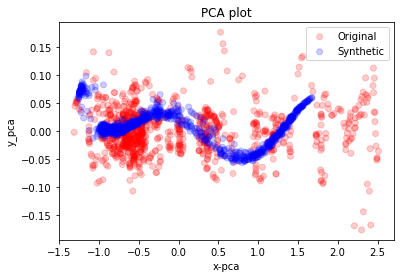

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.115s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.025741
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.348476
[t-SNE] KL divergence after 300 iterations: 0.618964


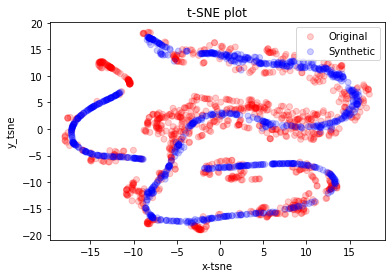

In [14]:
visualization(train_data, generated_data, 'pca')
visualization(train_data, generated_data, 'tsne')

In [15]:
!mv ./pca-results-stock-sce1-wTest.png ./figures_timegan_sce1_wTest
!mv ./tsne-results-stock-sce1-wTest.png ./figures_timegan_sce1_wTest

mv: cannot stat './pca-results-stock-sce1-wTest.png': No such file or directory
mv: cannot stat './tsne-results-stock-sce1-wTest.png': No such file or directory
